In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


In [2]:
fName = "../data/20190103-22-53-substorms.csv"

In [3]:
smssDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smssDF.columns = [ "datetime", "mlat", "mlt" ]
# convert to hour
smssDF['hour'] = pandas.DatetimeIndex(smssDF['datetime']).hour
smssDF.head()

,datetime,mlat,mlt,hour
0,1996-01-01 20:16:00,71.32,22.45,20
1,1996-01-01 23:36:00,70.23,0.07,23
2,1996-01-02 00:25:00,69.36,22.92,0
3,1996-01-02 14:12:00,70.06,23.20,14
4,1996-01-02 16:09:00,65.81,0.62,16


In [4]:
hrDF = smssDF.groupby(["hour"]).size()

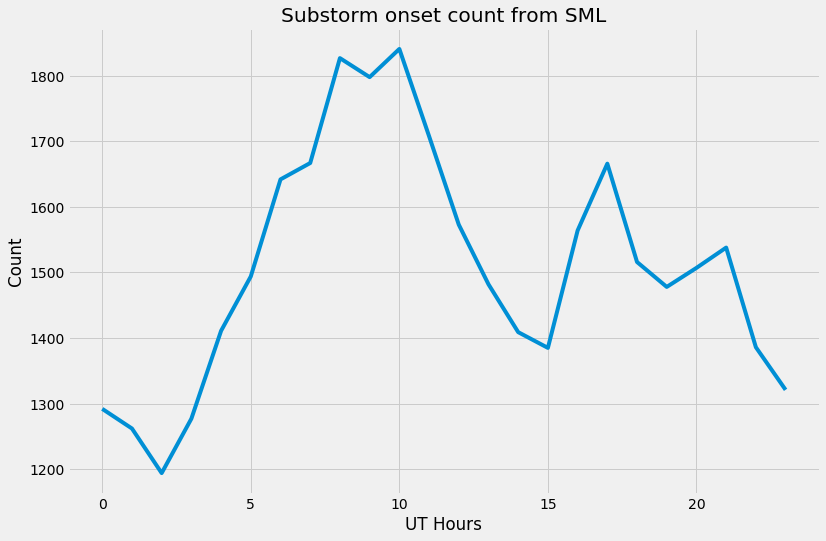

In [5]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrDF.index.values, hrDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
ax.set_title("Substorm onset count from SML")
fig.savefig("../plots/hours_count_sml_onset.png")

In [6]:
colNames = ["date"]
nBins = 1
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
colNames += [ "label", "pred_label" ]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]

In [7]:
predDF = pandas.read_csv("../data/test_data_pred_rf.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF['hour'] = pandas.DatetimeIndex(predDF['date']).hour

ParserError: Too many columns specified: expected 6 and found 4

In [ ]:
onsetDF = predDF[ predDF["pred_label"] == 1 ]
noOnsetDF = predDF[ predDF["pred_label"] == 0 ]
predDF.head()

In [ ]:
hrOnsetDF = onsetDF.groupby(["hour"]).size()
hrnOnsetDF = noOnsetDF.groupby(["hour"]).size()
allHrDF = predDF.groupby(["hour"]).size()

In [ ]:
print hrOnsetDF.index.values
print hrOnsetDF.values

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(allHrDF.index.values.astype(float), allHrDF.values.astype(float))
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
# ax.set_ylim([12000,14000])
fig.savefig("../plots/hours_count_pred_all.png")

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrOnsetDF.index.values, hrOnsetDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
fig.savefig("../plots/hours_count_pred_onset.png")

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrnOnsetDF.index.values, hrnOnsetDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
fig.savefig("../plots/nonset.png")

In [ ]:
predDF.head()

In [ ]:
uniqHours = numpy.sort(predDF["hour"].unique())
prDict = {}
# prDict["hour"] = []
prDict["prn1"] = []
prDict["rec1"] = []
prDict["prn0"] = []
prDict["rec0"] = []
prDict["cnt01"] = []
prDict["pred_cnt01"] = []
for _uqh in uniqHours:
#     prDict["hour"].append(_uqh)
    _selDF = predDF[predDF["hour"] == _uqh]
    # filter true positives and other parameters for 1's
    _tp1 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 1) ].shape[0])
    _fp1 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 0) ].shape[0])
    _fn1 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 1) ].shape[0])
    _pred_cnt1 = round(\
            float(_selDF[ (_selDF["pred_label"] == 1) ].shape[0]))
    _cnt1 = round(\
            float(_selDF[ (_selDF["label"] == 1) ].shape[0]))
    # and get precision and recall for 1's
    prDict["prn1"].append(round(_tp1/(_tp1+_fp1),2))
    prDict["rec1"].append(round(_tp1/(_tp1+_fn1),2))
    # similar calculations for 0's
    _tp0 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 0) ].shape[0])
    _fp0 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 1) ].shape[0])
    _fn0 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 0) ].shape[0])
    _pred_cnt0 = round(\
            float(_selDF[ (_selDF["pred_label"] == 0) ].shape[0]))
    _cnt0 = round(\
            float(_selDF[ (_selDF["label"] == 0) ].shape[0]))
    prDict["cnt01"].append( round((_cnt0/_cnt1),2) )
    prDict["pred_cnt01"].append( round((_pred_cnt0/_pred_cnt1),2) )
    prDict["prn0"].append(round(_tp0/(_tp0+_fp0),2))
    prDict["rec0"].append(round(_tp0/(_tp0+_fn0),2))

# convert to a DF
prDF = pandas.DataFrame(prDict, index=uniqHours)
prDF

In [ ]:
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(nrows=1, ncols=1,\
                    figsize=(12,8), sharex=True)
sns.heatmap(prDF, annot=True, cmap="GnBu", ax=axes) 
axes.set_ylabel("UT Hours")
fig.tight_layout()
fig.savefig("../plots/UT_prn_rec.png")